a district typically has a population of 600 to 3,000

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("data/housing.tgz")
  if not tarball_path.is_file():
    Path("data").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="data")
  return pd.read_csv(Path("data/housing/housing.csv"))
housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# Code to save the figures as high-res PNGs for the book
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

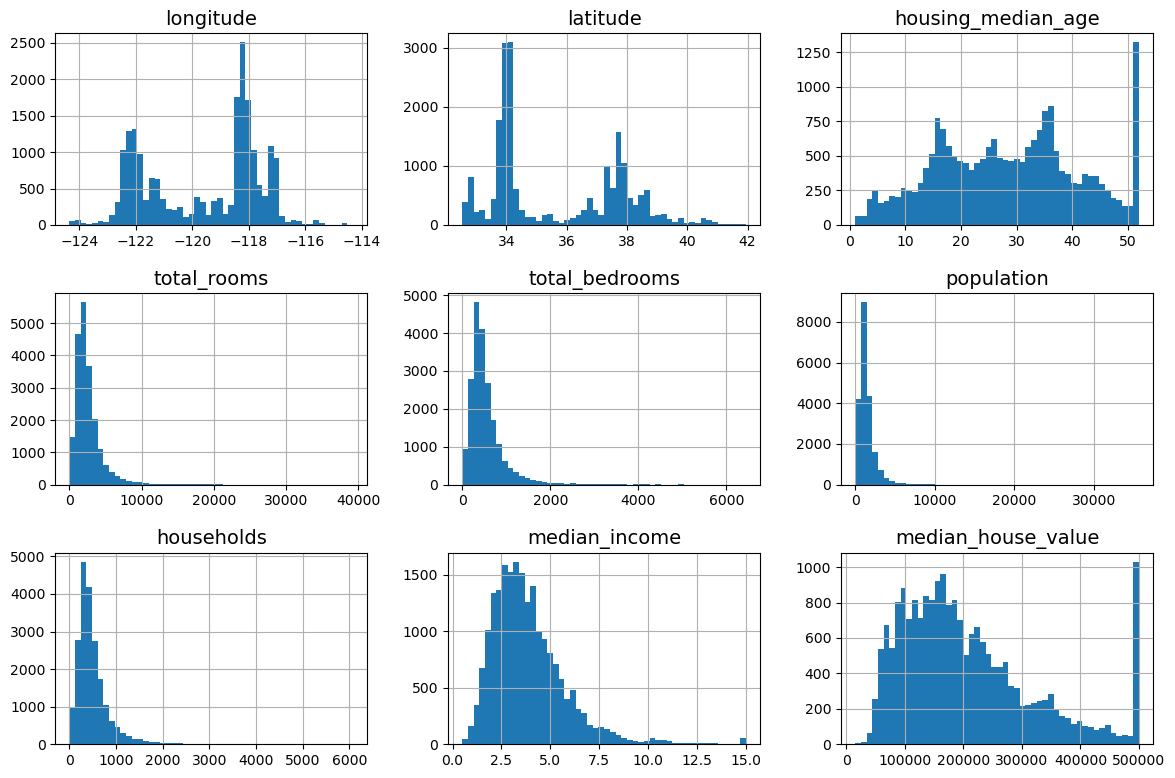

In [7]:
import matplotlib.pyplot as plt

# Define the default font sizes
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots") # Save the plot
plt.show()

Looking at these histograms:
* The median income attribute does not look like it is expressed in US dollars. After checking with the team that collected the data, they told us that the data has been scaled and capped at 15 for higher median incomes, and at 0.5 for lower median incomes. The numbers represent roughly tens of thousands (3 means about 30,000)
* The housing median age and the median house value were also capped. The latter may be a serious problem since it is our target attribute (labels). We need to check with our client team to see if this is a problem or not. If they tell you that they need precise predictions even beyond 500,000, then you have two options:
    1. Collect proper labels for the districts whose labels were capped
    2. Remove those disctricts from the training set (and also from the test set, since your model should not be evaluated poorly if it predicts values beyond 500,000)
* These attributes have very different scales
* Many histograms are skewed right

# Create a Test Set

In [8]:
import numpy as np
def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

To have a stable train/test split even after updating the dataset, a common solution is to use each instance's identifier to decide whether or not it should go int the test set. For example, you could compute a hash is lower than or equal to 20% of the maximum has value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset.

The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.


In [10]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district's latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID

In [12]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is `train_test_split()`, which does pretty much the same thing as the `shuffle_and_split_data()` function we defined earlier, with a couple of additional features.
* First, there is a `random_state` parameter that allows you to set the random generator seed
* Second, you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices

In [13]:
from sklearn.model_selection import train_test_split
train_test, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**Stratified Sampling**: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that test set is representative of the overall population

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

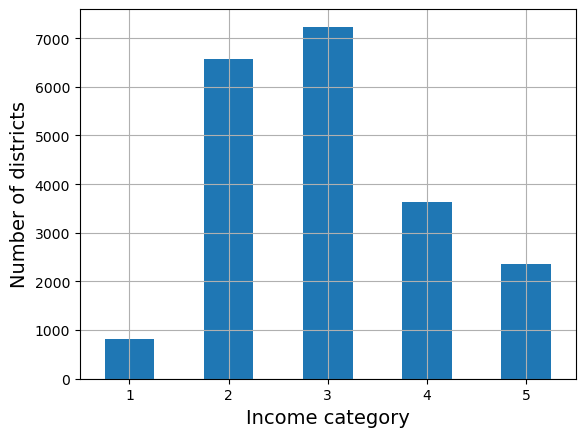

In [15]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

The following code generates 10 different stratified of the same dataset

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [17]:
strat_train_set, strat_test_set = strat_splits[0]

In [18]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
def income_cat_proportions(data):
  return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set)
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)
(compare_props*100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed

In [21]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

# Explore and Visualize the Data to Gain Insights

In [22]:
housing = strat_train_set.copy()

# Visualizing Geographical Data

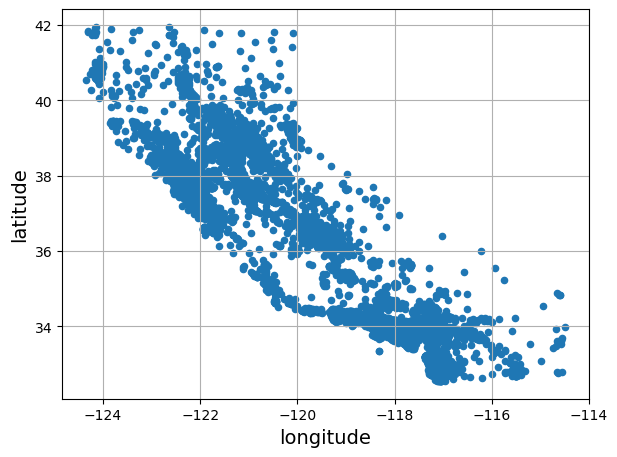

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

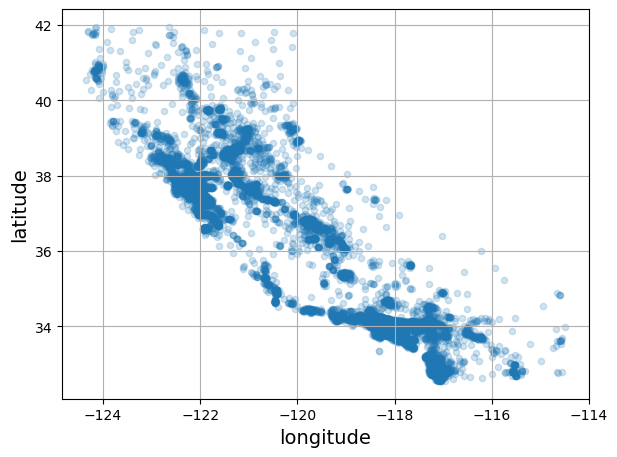

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2) # alpha is used to point out the high density of data points
save_fig("better_visualization_plot")
plt.show()

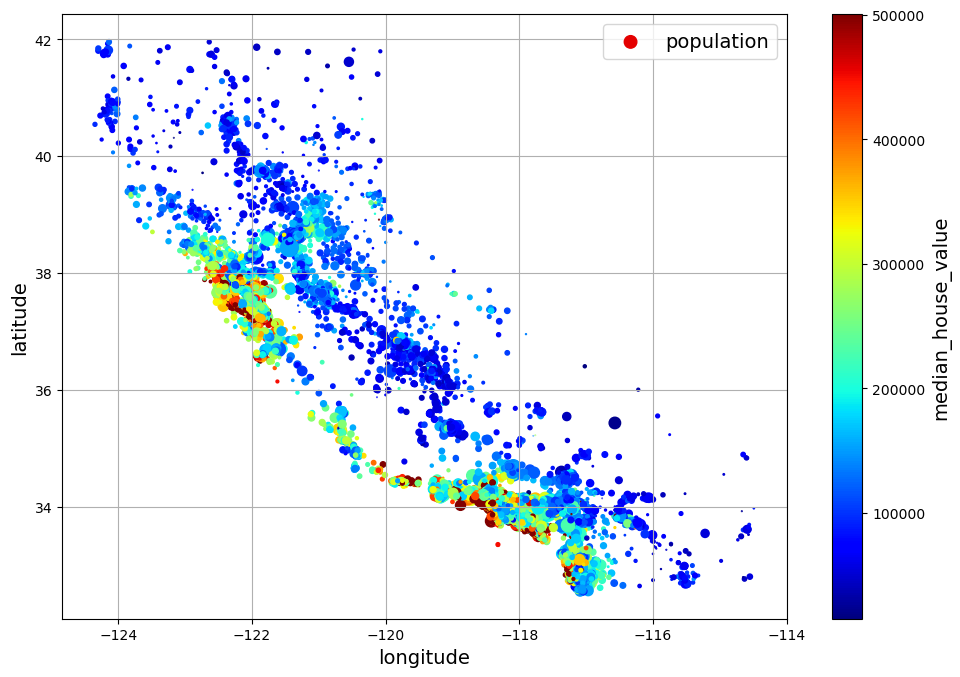

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100,
             label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))
save_fig("housing_price_scatterplot")
plt.show()

The radius of each circle represents the district's population (option `s`), and the color represents the price (option `c`). The color map `cmap` uses a predefined color map called `jet`, which ranges from blue (low values) to red (high prices)

# Look for Correlations

In [26]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [27]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

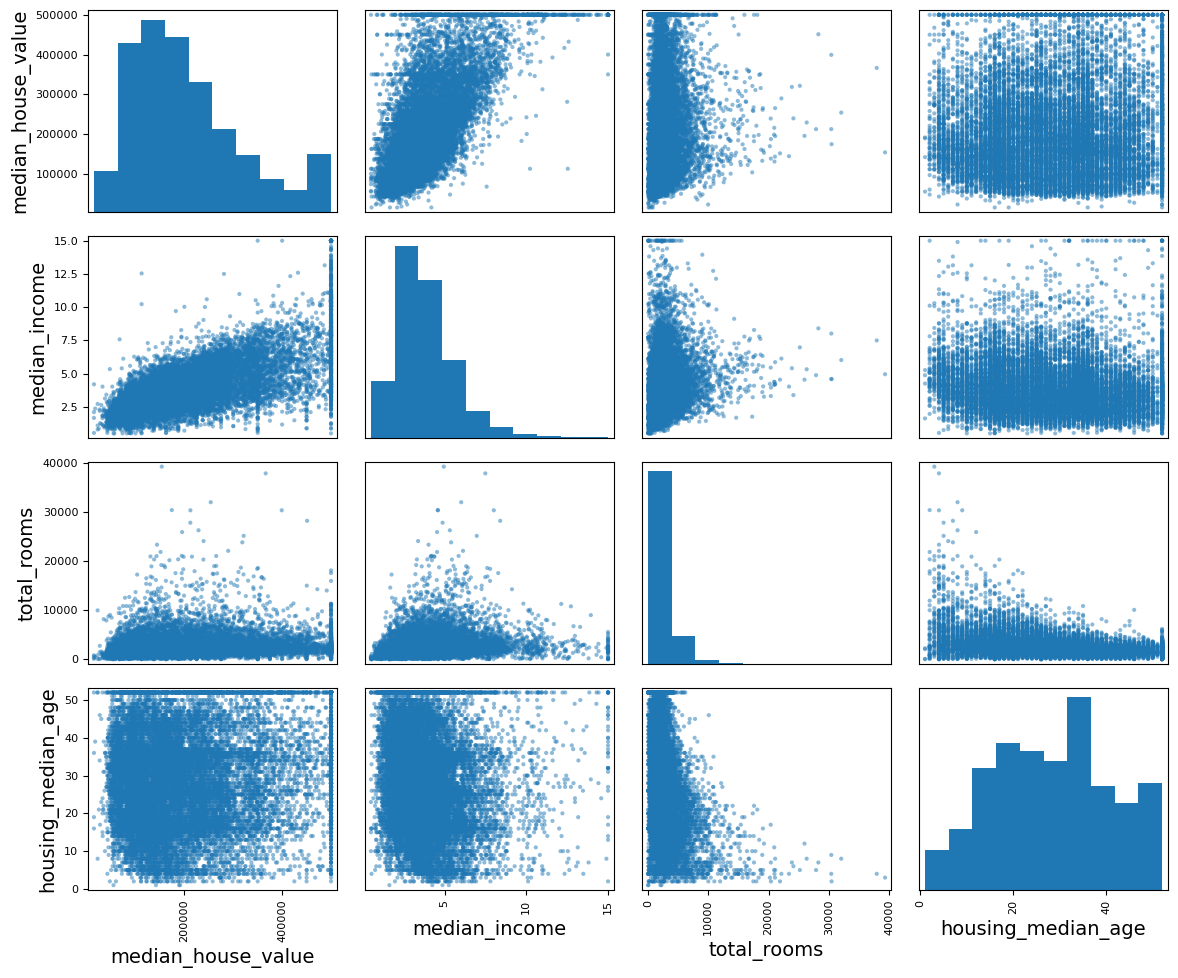

In [28]:
from pandas.plotting import scatter_matrix

attributes=["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 10))
save_fig("scatter_matrix_plot")
plt.show()

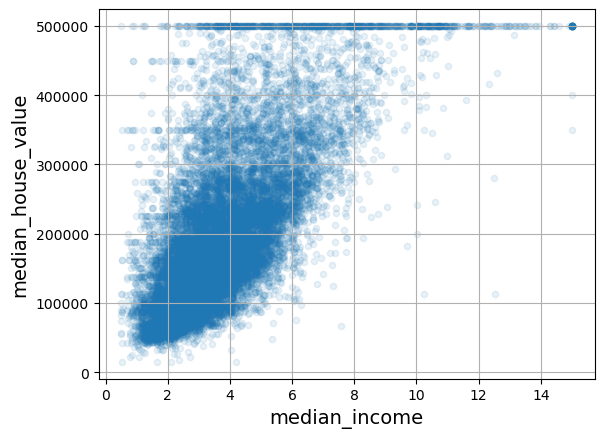

In [29]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

# Experimenting with Attribute Combinations

In [30]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [31]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

In [32]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"]

## Data Cleaning

To deal with missing values, there are three options to take:
1. Get rid of the corresponding districts/instances
2. Get rid of the whole attribute
3. Set the missing values to some value (zero, the mean, the median, etc.) / Imputation

In [33]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Separate the numerical attributes to use the `median` strategy (as it cannot be calculated on text attributes like `ocean_proximity`)

In [34]:
housing_num = housing.select_dtypes(include=[np.number])

In [36]:
# Fit the imputer instance to the training data
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [37]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [38]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [39]:
X = imputer.transform(housing_num)

Recover the column names and index of `housing_num` as Scikit-learn transformers only output NumPy arrays

In [40]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

# Handling Text and Categorical Attributes

In [41]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [42]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [43]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [45]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [48]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [49]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [50]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

When you fit any Scikit-Learn estimator using a Dataframe, the estimator stores the column names in the `feature_names_in_` attribute. Scikit-Learn then ensures that any DataFrame fed to this estimator after that has the same column names

In [51]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [52]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

## Feature Scaling and Transformation

In [53]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [54]:
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]], shape=(16512, 8))

In [55]:
len(housing_num_min_max_scaled)

16512

In [56]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [57]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
housing_num_std_scaled

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]], shape=(16512, 8))

If a feature's distribution has a heavy tail, you should first transform it to shrink the heavy tail, and if possible to make the distribution roughly symmetrical.

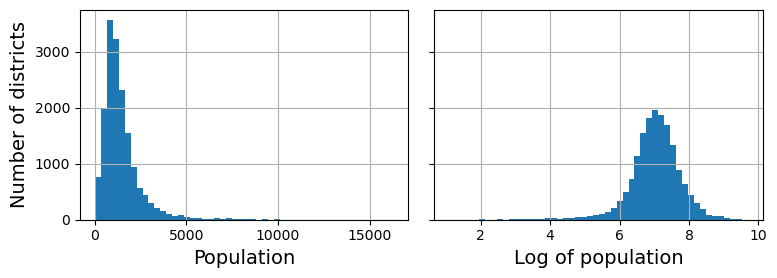

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

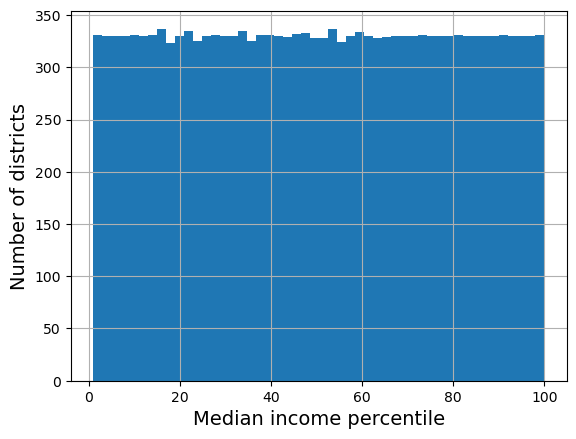

In [59]:
# Replace each value with its percentile (bucketizing)
percentiles = [np.percentile(housing["median_income"], p) for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"], bins=[-np.inf] + percentiles + [np.inf], labels=range(1, 100+1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

When a feature has a multimodal distribution, we can add a feature for each of the modes (at least the main ones), representing the similarity between the feature and that particular mode (peak). The similarity measure is typically computed using a Radial Basis Function (RBF)

Radial Basis Function (RBF) - any function that depends only on the distance between the input value and a fixed point (i.e. the Gaussian RBF similarity between the housing age `x` and 35 is given by the equation exp(-$\gamma$(`x`-35)^2)).

$\gamma$ determines how quickly the similarity measure decays as `x` moves away from 35.

In [60]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [61]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))

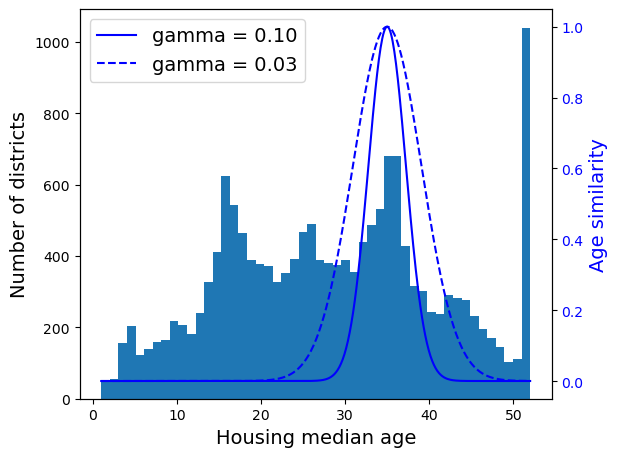

In [62]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [63]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame()) # StandardScaler expects 2D inputs

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

`TransformedTargetRegressor` will automatically use the transformer to scale the labels and train the regression model on the resulting scaled labels. Then, when we want to make a prediction, it will call the regression model's `predict()` method and use the scaler's `inverse_transform()` method to produce the prediction

In [64]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [65]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers

Sometimes you will need to write your own transformer for tasks such as custom transformations, cleanup operations, or combining specific attributes.

In [66]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [67]:
rbl_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbl_transformer.transform(housing[["housing_median_age"]])

In [68]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [69]:
sf_simil, sf_simil.shape

(array([[0.999927  ],
        [0.05258419],
        [0.94864161],
        ...,
        [0.00388525],
        [0.05038518],
        [0.99868067]], shape=(16512, 1)),
 (16512, 1))

In [70]:
# Custom Transformer are also useful to combine features
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

By adding `TransformerMixin` as a base class, we can get `fit_transform()`.

By adding `BaseEstimator` as a base class, we can get `get_params()` and `set_params()` which are useful for automatic hyperparameter tuning.

In [71]:
# Custom transformer that acts much like the StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True): # no *args or **kwargs
    self.with_mean = with_mean
  def fit(self, X, y=None):
    X = check_array(X) # checks that X is an array with finite float values
    self.mean_ = X.mean(axis=0)
    self.scale_ = X.std(axis=0)
    self.n_features_in_ = X.shape[1] # every estimator stores this is fit()
    return self # always return self
  def transform(self, X):
    check_is_fitted(self) # looks for learned attributes (with trailing)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean__
    return X / self.scale_

A custom transformer can use other estimators in its implementation.

You can check whether your custom estimator respects Scikit-Learn's API by passing an instance to `check_estimator()` from `sklearn.utils.estimator_checks` package.

In [72]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state
  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self # always return self
  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [73]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
# The transformer uses k-means to locate the clusters, then measures the RBF similarity between each district with all 10 cluster centers
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

D:\machine_learning\env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\machine_learning\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\machine_learning\env\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\machine_learning\env\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\machine_learning\env\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(

In [74]:
similarities[:3].round(2), len(similarities)

(array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
        [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
        [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]]),
 16512)

In [75]:
cluster_simil.get_feature_names_out()

['Cluster 0 similarity',
 'Cluster 1 similarity',
 'Cluster 2 similarity',
 'Cluster 3 similarity',
 'Cluster 4 similarity',
 'Cluster 5 similarity',
 'Cluster 6 similarity',
 'Cluster 7 similarity',
 'Cluster 8 similarity',
 'Cluster 9 similarity']

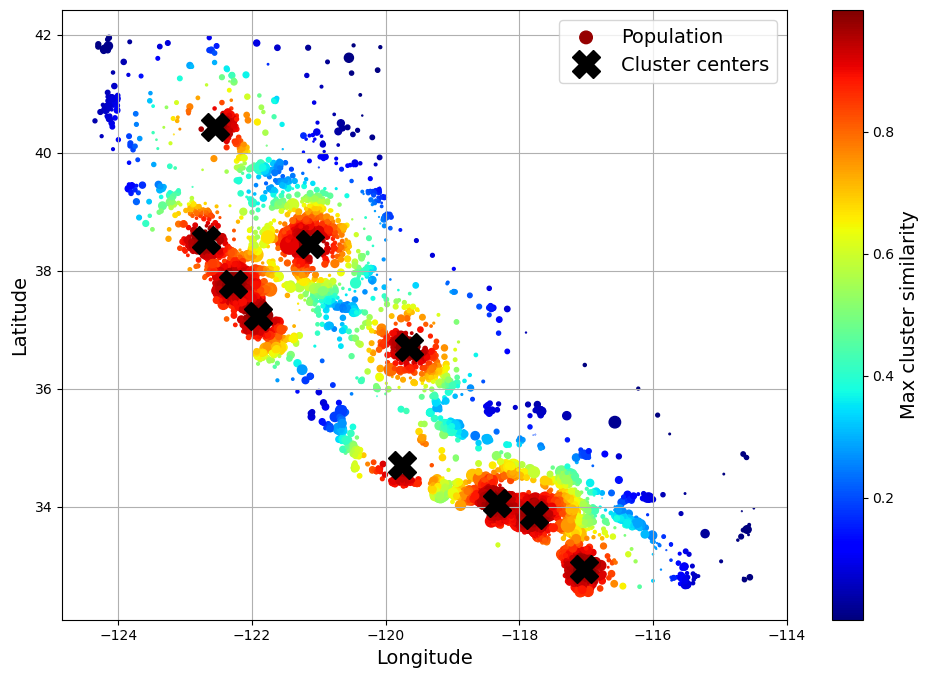

In [76]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

## Transformation Pipelines

`Pipeline` helps ordering a sequences of transformations. It takes a list of estimator pairs defining a sequence of steps. (unique_name_without_doubleUnderscores, transformers)

In [77]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

If you prefer to not name the transformers, you can use `make_pipeline()` instead

In [78]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             StandardScaler())

In [79]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [80]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


In [81]:
num_pipeline[1]

StandardScaler()

In [82]:
num_pipeline["simpleimputer"]

SimpleImputer(strategy='median')

In [83]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

If you don't care about naming the transformers, you can use `make_column_transformer()`, and `make_column_selector()` to select all the features of a given type

In [84]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [85]:
housing_prepared = preprocessing.fit_transform(housing)

In [86]:
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]], shape=(16512, 13))

In [87]:
housing_prepared_df = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)
housing_prepared_df

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041,1.0,0.0,0.0,0.0,0.0
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630,0.0,1.0,0.0,0.0,0.0
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049,0.0,0.0,0.0,0.0,1.0
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396,1.0,0.0,0.0,0.0,0.0


In [88]:
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"] # feature names out

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ratio, feature_names_out=ratio_name),
      StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms","households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households",
                           "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline) # one column remaining: housing_median_age

In [89]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [90]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model

## Train and Evaluate on the Training Set

In [91]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A32F7D1110>)])),
                ('linearregression', LinearRegression())])

In [92]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2) # rounded to the nearest hundred

array([246000., 372700., 135700.,  91400., 330900.])

In [93]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [94]:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100*ratio:.1f}%" for ratio in error_ratios]))

-46.3%, -23.0%, 33.4%, -4.9%, -8.5%


In [95]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

np.float64(68972.88910758475)

In [96]:
min(strat_train_set["median_house_value"]), max(strat_train_set["median_house_value"])

(14999.0, 500001.0)

In [97]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A32F7D1110>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [98]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

np.float64(0.0)

## Evaluation using Cross-Validation

Scikit Learn's cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the RMSE.

It's a negative value, so you need to switch the sign of the output to get the RMSE scores.

In [99]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [100]:
tree_rmses

array([64849.19574692, 67830.59296019, 66734.74035037, 66900.3640754 ,
       64289.37619843, 68243.50238557, 66988.9328623 , 68454.11092405,
       68659.29429046, 67183.49969976])

The cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise the estimate is.

In [101]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67013.360949
std       1460.198570
min      64289.376198
25%      66776.146282
50%      67086.216281
75%      68140.275029
max      68659.294290
dtype: float64

In [102]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     70003.404818
std       4182.188328
min      65504.765753
25%      68172.065831
50%      68743.995249
75%      70344.943988
max      81037.863741
dtype: float64

In [103]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [104]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47124.604437
std       1069.311372
min      45292.329302
25%      46712.106520
50%      47172.209883
75%      47561.377695
max      49354.705514
dtype: float64

In [105]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

np.float64(17519.685029292894)

# Fine-Tune Your Model

## Grid Search

In [106]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid=[
    {
        "preprocessing__geo__n_clusters": [5, 8, 10],
        "random_forest__max_features": [4, 6, 8],
    },
    {
        "preprocessing__geo__n_clusters": [10, 15],
        "random_forest__max_features": [6, 8, 10],
    }
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A32F7D1110>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [107]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [108]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000002A...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A32F841AD0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [109]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters", "param_random_forest__max_features", "split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols # renaming
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43521,43958,44760,44080
13,15,8,44027,44180,45007,44405
14,15,10,44403,44619,45424,44815
7,10,6,44251,44825,45611,44896
9,10,6,44251,44825,45611,44896


## Randomized Search

In [110]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {
    "preprocessing__geo__n_clusters": randint(low=3, high=50),
    "random_forest__max_features": randint(low=2, high=20)
}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
                                scoring="neg_root_mean_squared_error", random_state=42)
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A32F841890>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A3307A0750>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [111]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters", "param_random_forest__max_features", "split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols # renaming
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41204,42108,42998,42103
8,32,7,41991,42557,43431,42660
5,42,4,42031,42968,43617,42872
0,41,16,42580,42869,43604,43018
2,23,8,42421,42841,44232,43165


**Sampling Distribution for a Hyperparameter**:
* `scipy.stats.randint(a, b+1)`: for hyperparameters with discrete values that range from a to b, and all values in that range seem equaly likely
* `scipy.stats.uniform(a, b)`: this is very similar, but for continuous hyperparameter
* `scipy.stats.geom(1/scale)`: for discrete values, when you want to sample roughly in a given scale (e.g. with scale=1000 most samples will be given this ballpark, but ~10% of all samples will be < 100 and ~10% will be > 2300)
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value
* `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optional hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100

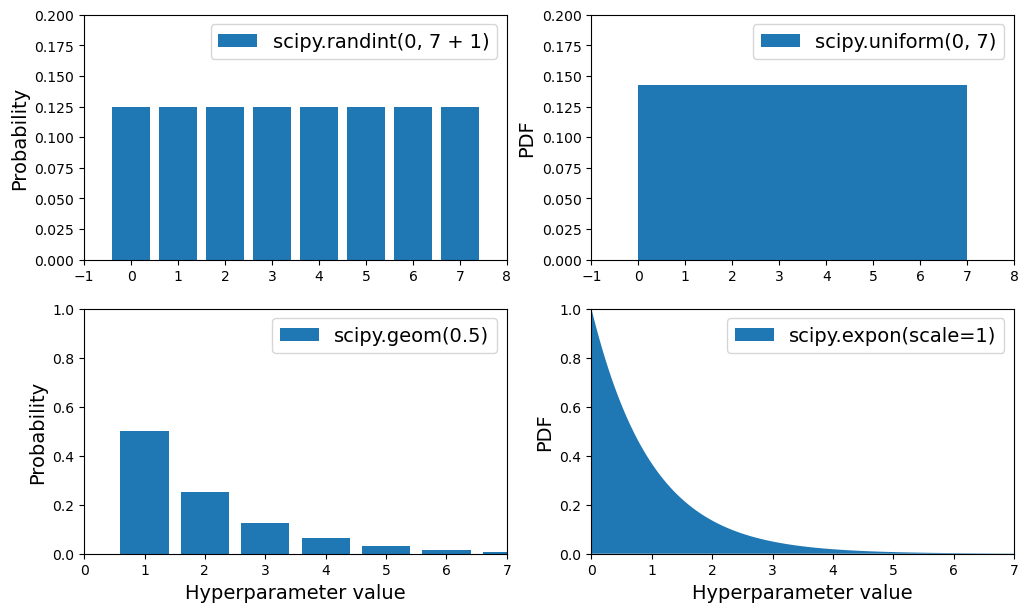

In [112]:
# a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

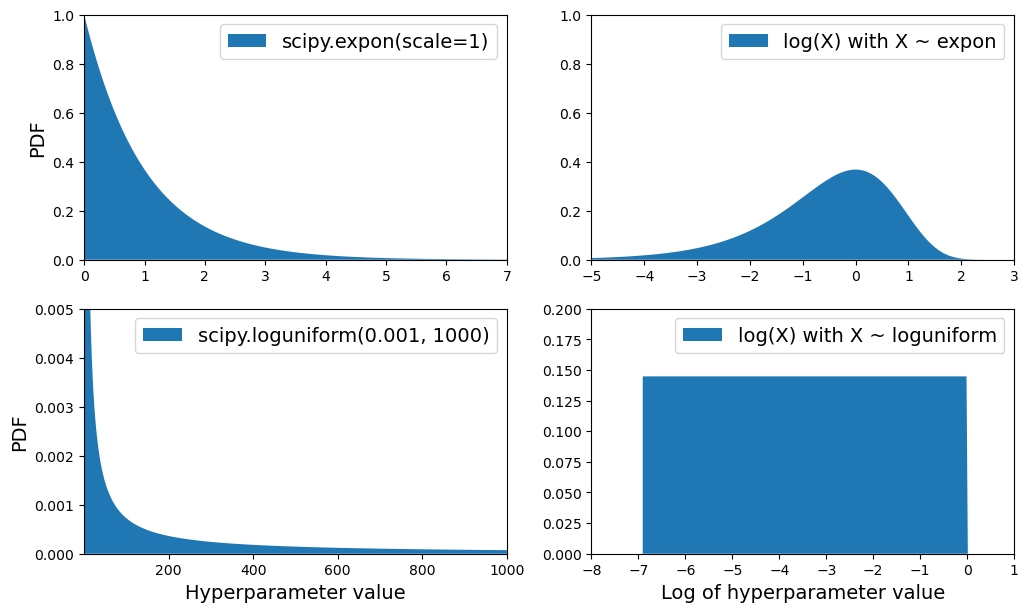

In [113]:
# shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Ensemble Methods

You can try to combine the models that perform best - just like random forest performs better than the individual decision trees they rely on


# Analyzing the Best Models and Their Errors

In [114]:
final_model = rnd_search.best_estimator_ # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.02, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.01,
       0.01, 0.  , 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.04, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [115]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(np.float64(0.18836603202647126), 'log__median_income'),
 (np.float64(0.07795960969938898), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06110388595864347), 'bedrooms__ratio'),
 (np.float64(0.05772194900488602), 'rooms_per_house__ratio'),
 (np.float64(0.04569274355282605), 'people_per_house__ratio'),
 (np.float64(0.041977095119231075), 'geo__Cluster 30 similarity'),
 (np.float64(0.024893290428216707), 'geo__Cluster 9 similarity'),
 (np.float64(0.02349145973584661), 'geo__Cluster 36 similarity'),
 (np.float64(0.021384735075780065), 'geo__Cluster 18 similarity'),
 (np.float64(0.019231937253583756), 'geo__Cluster 3 similarity'),
 (np.float64(0.019114201150802552), 'geo__Cluster 32 similarity'),
 (np.float64(0.01740110192655986), 'geo__Cluster 25 similarity'),
 (np.float64(0.01628160145237179), 'geo__Cluster 1 similarity'),
 (np.float64(0.015974756525084677), 'geo__Cluster 26 similarity'),
 (np.float64(0.014014150061434243), 'geo__Cluster 7 similarity'),
 (np.float64(0.01358828420690533

# Evaluate Your System on the Test Set

In [116]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
final_rmse

np.float64(41422.168800999665)

95% confidence interval for the generalization error using `scipy.stats.t.interval()`

In [117]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                       loc=squared_errors.mean(),
                       scale=stats.sem(squared_errors)))

array([39272.70918656, 43465.46272048])

In [118]:
final_model.score(X_test, y_test)

0.8718212368177203

# Model Persistence using joblib

In [119]:
import joblib
joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

1. You can put your model in your web application, say your model will be used within a website, then your code will simply call the model's `predict()` method to give the result from user's query
2. You can wrap the model within a dedicated web service that your web application can query through a REST API
3. You can also deploy your model to the cloud, such as Google's Vertex AI, to save your model using `joblib` and upload it to Google Cloud Storage (GCS), then head over to Vertex AI and create a new model version, pointing it to the GCS file.

The following code could be a script that would run in production:

In [120]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
predictions

array([440208.11, 457822.08, 106671.  , 100105.  , 330637.02])

# Exercises

## 1
Use support vector machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameter).

Note that SVM don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold-cross-validation

In [121]:
from sklearn.svm import SVR
param_grid = [
    {
        "svr__kernel": ["linear"],
        "svr__C": [10., 30., 100., 300., 1000.,
                   3000., 10000., 30000.0],
    },
    {
        "svr__kernel": ["rbf"],
        "svr__C": [1.0, 3.0, 10., 30., 100., 300., 1000.0],
        "svr__gamma": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
    },
]

svr_pipeline = make_pipeline(preprocessing, SVR())
svr_search = GridSearchCV(svr_pipeline, param_grid=param_grid, cv=3, scoring="neg_root_mean_squared_error")
svr_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_ou...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A32F7D1110>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [122]:
cv_res = pd.DataFrame(svr_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_svr__kernel", "param_svr__C", "param_svr__gamma", "split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["kernel", "C", "gamma"] + score_cols # renaming
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,kernel,C,gamma,split0,split1,split2,mean_test_rmse
6,linear,10000.0,NaN,73194,70837,66149,70060
7,linear,30000.0,NaN,75336,69778,65311,70142
5,linear,3000.0,NaN,73092,72244,68036,71124
4,linear,1000.0,NaN,74098,73915,69718,72577
3,linear,300.0,NaN,76238,76285,72095,74873


In [123]:
svr_search.best_params_, -svr_search.best_score_

({'svr__C': 10000.0, 'svr__kernel': 'linear'}, np.float64(70059.92773161597))

In [124]:
svr_best_model = svr_search.best_estimator_
svr_best_model.score(X_test, y_test)

-18.88975006273735

## 2
Replace the `GridSearchCV` with a `RandomizedSearchCV`

We used the `expon()` distribution for `gamma` with a scale of 1, so `RandomSearch` mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger)

We Used `loguniform()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000

In [125]:
param_distribs ={
    "svr__kernel": ["linear", "rbf"],
    "svr__C": loguniform(20, 20_000),
    "svr__gamma": expon(scale=1.0)
}
rnd_search = RandomizedSearchCV(svr_pipeline, param_distributions=param_distribs,
                                n_iter=50, cv=3, scoring="neg_root_mean_squared_error",
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_na...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002A32F7D1110>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A32B4BEE50>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A32D5A4ED0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [126]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_svr__kernel", "param_svr__C", "param_svr__gamma", "split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["kernel", "C", "gamma"] + score_cols # renaming
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,kernel,C,gamma,split0,split1,split2,mean_test_rmse
9,rbf,16683.860588,0.264970,62461,61943,58697,61034
11,linear,17812.408772,0.628789,73885,70212,65473,69857
22,linear,11658.769086,0.092655,73484,70680,66011,70058
49,linear,10507.885221,0.317636,73355,70757,66123,70078
14,linear,5323.803777,0.363288,72971,71437,67425,70611


In [127]:
rnd_search.best_params_

{'svr__C': np.float64(16683.860588281554),
 'svr__gamma': np.float64(0.26497040005002437),
 'svr__kernel': 'rbf'}

## 3
Add a `SelectFromModel` transformer in the preparation pipeline to select only the most important attributes from `RandomForestRegressor`

In [128]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("selector", SelectFromModel(RandomForestRegressor(random_state=42))),
    ("svr", SVR(kernel=rnd_search.best_params_["svr__kernel"],
                gamma=rnd_search.best_params_["svr__gamma"],
                C=rnd_search.best_params_["svr__C"]))
])

In [129]:
selector_rmse = -cross_val_score(selector_pipeline, housing.iloc[:5000], housing_labels.iloc[:5000],
                                 scoring="neg_root_mean_squared_error", cv=3)
pd.Series(selector_rmse)

0    66008.992590
1    64275.984720
2    62220.157273
dtype: float64

In [130]:
pd.Series(selector_rmse).describe()

count        3.000000
mean     64168.378194
std       1896.708369
min      62220.157273
25%      63248.070996
50%      64275.984720
75%      65142.488655
max      66008.992590
dtype: float64

## 4
Create a custom transformer that trains a *k-nearest neighbors regressor* (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's prediction in its `transform()` method. Then, add this feature to the preprocessing pipeline, using `latitude` and `longitude` as the inputs to this transformer.

This will ad a feature in the model that corresponds to the housing median price of the nearest districts

The `MetaEstimatorMixin` will ensure that `estimator` is listed as a required parameters, and it will update `get_params()` and `set_params()` to make the estimator's hyperparameters available for tuning.

The `fit()` method must work on a clone of this estimator because the Python's mutability of an object, and it must also save `feature_names_in_`.

In [131]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin, MetaEstimatorMixin, clone
from sklearn.utils.validation import check_is_fitted

class FeatureFromRegressor(MetaEstimatorMixin, TransformerMixin, BaseEstimator):
  def __init__(self, estimator):
    self.estimator = estimator

  def fit(self, X, y=None):
    check_array(X)
    self.estimator_ = clone(self.estimator)
    self.estimator_.fit(X, y)
    self.n_features_in_ = self.estimator_.n_features_in_
    if hasattr(self.estimator_, "feature_names_in_"):
      self.feature_names_in = self.estimator_.feature_names_in_
    return self

  def transform(self, X):
    check_is_fitted(self)
    predictions = self.estimator_.predict(X)
    if predictions.ndim == 1:
      predictions = predictions.reshape(-1, 1)
    return predictions

  def get_feature_names_out(self, names=None):
    check_is_fitted(self)
    n_outputs = getattr(self.estimator_, "n_outputs_", 1)
    estimator_class_name = self.estimator_.__class__.__name__
    estimator_short_name = estimator_class_name.lower().replace("_", "")
    return [f"{estimator_short_name}_prediction_{i}" for i in range(n_outputs)]

Ensure it complies to Scikit-Learn's API

In [132]:
from sklearn.utils.estimator_checks import check_estimator

test_results = check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

In [133]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

array([[486100.66666667],
       [435250.        ],
       [105100.        ],
       ...,
       [148800.        ],
       [500001.        ],
       [234333.33333333]], shape=(16512, 1))

In [134]:
knn_transformer.get_feature_names_out()

['kneighborsregressor_prediction_0']

In [135]:
from sklearn.base import clone

transformers = [(name, clone(transformer), columns) for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _, _ in transformers].index("geo")
transformers[geo_index] = ("geo", knn_transformer, ["latitude", "longitude"])

new_geo_preprocessing = ColumnTransformer(transformers)

In [136]:
new_geo_pipeline = Pipeline([
    ("preprocessing", new_geo_preprocessing),
    ("svr", SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"]))
])

In [137]:
new_pipe_rmse = -cross_val_score(new_geo_pipeline, housing.iloc[:5000], housing_labels.iloc[:5000],
                                 scoring="neg_root_mean_squared_error", cv=3)
pd.Series(new_pipe_rmse).describe()

count         3.000000
mean     111681.587283
std        3033.382031
min      108278.938946
25%      110471.100672
50%      112663.262399
75%      113382.911452
max      114102.560506
dtype: float64

## 5
Explore some preparation option using `RandomizedSearchCV`

In [138]:
param_distribs = {
    "preprocessing__geo__estimator__n_neighbors": range(1, 30),
    "preprocessing__geo__estimator__weights": ["distance", "uniform"],
    "svr__C": loguniform(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline, param_distributions=param_distribs,
                                        n_iter=50, cv=3, scoring="neg_root_mean_squared_error",
                                        random_state=42)

new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x000002A32D5C9080>,
                                                                                                                    func=<function column_ratio at 0x000002A32D5C9C60>)),
                                                                                               ('standardscaler',
                                                                                                St...
                   param_distributions={'preprocessing__geo__estimator__n_neighbors': range(1, 30),
                                        'preprocessing__geo__estimator__weights': ['distance',
                                                                                   'uniform'],
                                        'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A32D5A5790>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A32A4F6F10>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [139]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

np.float64(106867.28961396824)

## 6
Implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler`.

`inverse_transform(scaler.fit_transform(X))` shold return an array very close to `X`. Then add support for feature names: set `feature_names_in_` in the `fit()` method if the input is a DataFrame. This attribute should be a NumPy array of column names.

Lastly, implement `get_feature_names_out()` method: it should have one optional `input_features=None` argument. If passed, the method should check that its length matches `n_features_in_`, and it should match `feature_names_in_` if it is defined. Then, the `input_features` should be returned. If `input_features` is `None`, then the method should either return `feature_names_in_` if it is defined or `np.array(["x0", "x1", ...])` with length `n_features_in_` otherwise.

In [140]:
# Custom transformer that acts much like the StandardScaler
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, validate_data
class StandardScalerClone(TransformerMixin, BaseEstimator):
  def __init__(self, with_mean=True): # no *args or **kwargs
    self.with_mean = with_mean

  def fit(self, X, y=None):
    X = validate_data(self, X, ensure_2d=True) # if the input is DataFrame, it will extract the column names and store those to feature_names_in_
    self.n_features_in_ = X.shape[1]
    if self.with_mean:
      self.mean_ = np.mean(X, axis=0)
    self.scale_ = np.std(X, axis=0, ddof=0)
    self.scale_[self.scale_ == 0] = 1 # Avoid division by 0
    return self # always return self

  def transform(self, X):
    check_is_fitted(self) # looks for learned attributes (with trailing)
    X = validate_data(self, X, ensure_2d=True, reset=False)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
    return X / self.scale_

  def inverse_transform(self, X):
    check_is_fitted(self)
    X = validate_data(self, X, ensure_2d=True, reset=False)
    return X * self.scale_ + self.mean_

  def get_feature_names_out(self, input_features=None):
    if input_features is None:
      return getattr(self, "feature_names_in_", [f"x{i}" for i in range(self.n_features_in_)])
    else:
      if len(input_features) != self.n_features_in_:
        raise ValueError("Invalid number of features")
      if hasattr(self, "feature_names_in_") and not np.all(self.feature_names_in_ == input_features):
        raise ValueError("input_features != feature_names_in_")
      return input_features

ImportError: cannot import name 'validate_data' from 'sklearn.utils.validation' (D:\machine_learning\env\Lib\site-packages\sklearn\utils\validation.py)

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(StandardScalerClone())

In [ ]:
np.random.seed(42)
X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X-X.mean(axis=0))/X.std(axis=0))

In [ ]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)
assert np.allclose(X_scaled_uncentered, X/X.std(axis=0))

In [ ]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))
assert np.allclose(X, X_back)

In [ ]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

In [ ]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])